In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

import tensorflow as tf
from tensorflow.keras import layers
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np




In [ ]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = (train_images - 127.5) / 127.5
test_images = (test_images - 127.5) / 127.5

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)


In [ ]:
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 9.8 MB/s eta 0:00:00


In [ ]:


noise_dim = 200

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(noise_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

import tensorflow_addons as tfa

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tfa.layers.SpectralNormalization(layers.Conv2D(96, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1])))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.1))

    model.add(tfa.layers.SpectralNormalization(layers.Conv2D(160, (5, 5), strides=(2, 2), padding='same')))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.1))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model


generator = make_generator_model()
discriminator = make_discriminator_model()

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
def generate_and_save_images(model, epoch, test_input):

  predictions = model(test_input, training=False)


  predictions = (predictions + 1) / 2.0


  fig = plt.figure(figsize=(4,4))
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')


  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()


In [ ]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

def train(dataset, epochs):

  seed = tf.random.normal([16, noise_dim])

  for epoch in range(epochs):
    gen_loss_list = []
    disc_loss_list = []

    for image_batch in dataset:
      gen_loss, disc_loss = train_step(image_batch)
      gen_loss_list.append(gen_loss)
      disc_loss_list.append(disc_loss)

    clear_output(wait=True)
    generate_and_save_images(generator, epoch + 1, seed)
    print ('Epoch:', epoch + 1)
    print ('Generator Loss: {:.4f}'.format(np.mean(gen_loss_list)))
    print ('Discriminator Loss: {:.4f}'.format(np.mean(disc_loss_list)))


  clear_output(wait=True)
  generate_and_save_images(generator, epochs, seed)


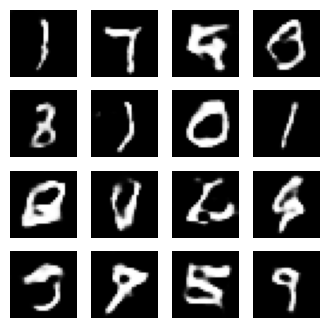

In [ ]:
BATCH_SIZE = 256

BUFFER_SIZE = 60000

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

train(train_dataset, epochs=200)